I will be using SNNtorch in order to write a spiking neural network and train it on MNIST. Check the docs for details. Spiking Neural networks take spiking inpututs and will produce spiking outputs. They try to mimic how our brain neurons work.
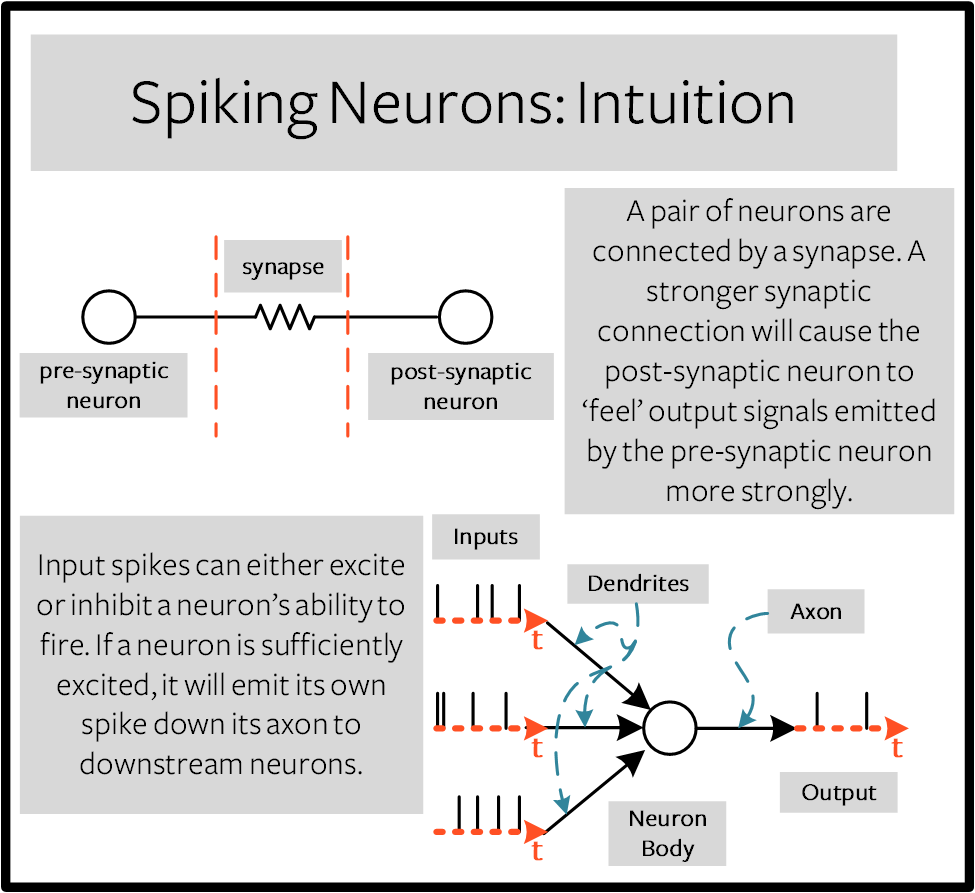

I will be using simplified LIF neruon model which is provide by snntorch as snn.Leaky()

The memberene potential of this model will be defined as:

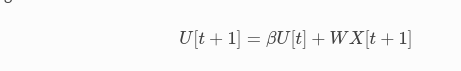


Where beta is the decay constant that causes collected memberene potential to decay over time. `W` is the weight(learnable parameter) and x[t+1] is the input(spike) at current timestep. The beta is a hyperparamter and I will take it as constant value.



In [3]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 9.3 MB/s eta 0:00:00


## 1. Necessary Imports

In [140]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import itertools


from tqdm import tqdm

## Defining the Dataset and loaders

In [11]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


In [141]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

subset_indices = torch.arange(128)
train_sub = Subset(mnist_train, subset_indices)
# Create DataLoaders

train_loader = DataLoader(train_sub, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

### Defining the Spiking Neural Network
The network will have these parameters.
num_inputs = 784
num_hiddens = 1500
num_outputs = 10

In [ ]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [128]:
class SnnNet(nn.Module):
  def __init__(self, num_inputs = 28*28, beta = 0.95, num_outputs = 10):
    super().__init__()
    self.num_steps = 25

    self.fc1 = nn.Linear(num_inputs, 1000)
    self.lif1 = snn.Leaky(beta)
    self.fc2 = nn.Linear(1000, num_outputs)
    self.lif2 = snn.Leaky(beta)


  def forward(self, x):
    mem1 = self.lif1.init_leaky()
    mem2 = self.lif2.init_leaky()

    ## recording outputs
    out_spk = []
    out_mem = []

    for step in range(self.num_steps):
      cur1 = self.fc1(x)    # W*x
      spk1, mem1 = self.lif1(cur1, mem1)

      cur2 = self.fc2(spk1)
      spk2, mem2 = self.lif2(cur2, mem2)

      out_spk.append(spk2)
      out_mem.append(mem2)

    return torch.stack(out_spk, dim=0), torch.stack(out_mem, dim=0)

## Overfitting the model on one training batch

In [144]:
def train_snn(criterion, optimizer, model, train_loader, val_loader, num_epochs = 50):
  loss_hist = []
  test_loss_hist = []

  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

  model = model.to(device)

  for epoch in range(num_epochs):

    print(f'Epoch ....... {epoch} / {num_epochs}')

    ## Training the model
    model.train()

    running_loss = 0
    for images, targets in tqdm(train_loader):
      images = images.to(device)
      targets = targets.to(device)

      out_spks, out_mem = model(images.view(images.shape[0], -1))

      #the shape of out_mem will be (time_step, B, Clas_prob) (25, 128, 10), shape of targets is (128)
      #cross entorpy expectes inputs (N, C, dims...) and targets in (N, dims..), where C is number of classes. So Need to make targets to that format.
      # We will sum the loss over time_steps whereas average over batch. Need to calculate loss for each steps and sum them
      targets = targets.view(128, 1).repeat(1, 25)

      loss = criterion(out_mem.permute(1, 2, 0), targets)
      loss = loss.mean(dim = 0).sum()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss+=loss.item()

      print('Loss:', running_loss)



In [150]:
model = SnnNet()
criterion = nn.CrossEntropyLoss(reduction = 'none')
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


In [151]:
train_snn(criterion, optimizer, model, train_loader, '0' )

Epoch ....... 0 / 50


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Loss: 59.18157958984375
Epoch ....... 1 / 50


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Loss: 46.39707946777344
Epoch ....... 2 / 50


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Loss: 40.59767532348633
Epoch ....... 3 / 50


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Loss: 36.605751037597656
Epoch ....... 4 / 50


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Loss: 33.292091369628906
Epoch ....... 5 / 50


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Loss: 30.326942443847656
Epoch ....... 6 / 50


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Loss: 27.65329360961914
Epoch ....... 7 / 50


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Loss: 24.926855087280273
Epoch ....... 8 / 50


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Loss: 22.234704971313477
Epoch ....... 9 / 50


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Loss: 19.338388442993164
Epoch ....... 10 / 50


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Loss: 16.958148956298828
Epoch ....... 11 / 50


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Loss: 14.565849304199219
Epoch ....... 12 / 50


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Loss: 12.482503890991211
Epoch ....... 13 / 50


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Loss: 10.689373970031738
Epoch ....... 14 / 50


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Loss: 9.223175048828125
Epoch ....... 15 / 50


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Loss: 7.927016258239746
Epoch ....... 16 / 50


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Loss: 6.7509355545043945
Epoch ....... 17 / 50


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Loss: 5.756865978240967
Epoch ....... 18 / 50


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Loss: 4.991208076477051
Epoch ....... 19 / 50


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Loss: 4.4153218269348145
Epoch ....... 20 / 50


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Loss: 3.9650232791900635
Epoch ....... 21 / 50


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Loss: 3.588491439819336
Epoch ....... 22 / 50


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Loss: 3.2919728755950928
Epoch ....... 23 / 50


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Loss: 3.0865044593811035
Epoch ....... 24 / 50


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Loss: 2.914695978164673
Epoch ....... 25 / 50


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Loss: 2.785283327102661
Epoch ....... 26 / 50


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Loss: 2.695378541946411
Epoch ....... 27 / 50


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Loss: 2.631870985031128
Epoch ....... 28 / 50


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Loss: 2.580226182937622
Epoch ....... 29 / 50


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Loss: 2.530749797821045
Epoch ....... 30 / 50


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Loss: 2.4662160873413086
Epoch ....... 31 / 50


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Loss: 2.4033734798431396
Epoch ....... 32 / 50


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Loss: 2.350123882293701
Epoch ....... 33 / 50


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Loss: 2.308659553527832
Epoch ....... 34 / 50


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Loss: 2.2746617794036865
Epoch ....... 35 / 50


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Loss: 2.245917558670044
Epoch ....... 36 / 50


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Loss: 2.215527057647705
Epoch ....... 37 / 50


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Loss: 2.1906962394714355
Epoch ....... 38 / 50


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Loss: 2.1650216579437256
Epoch ....... 39 / 50


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Loss: 2.1429269313812256
Epoch ....... 40 / 50


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Loss: 2.125491142272949
Epoch ....... 41 / 50


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Loss: 2.1079165935516357
Epoch ....... 42 / 50


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Loss: 2.0937325954437256
Epoch ....... 43 / 50


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Loss: 2.080095052719116
Epoch ....... 44 / 50


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Loss: 2.06661319732666
Epoch ....... 45 / 50


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Loss: 2.0556023120880127
Epoch ....... 46 / 50


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Loss: 2.0456442832946777
Epoch ....... 47 / 50


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Loss: 2.0339910984039307
Epoch ....... 48 / 50


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Loss: 2.0243265628814697
Epoch ....... 49 / 50


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

Loss: 2.014389991760254


## Output Prediction on trained Model.

We will take sample from train that was used for training and visulalize the overfitted output.

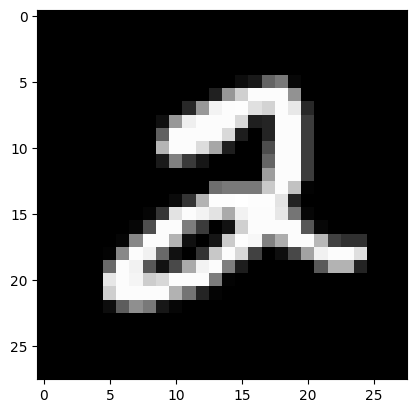

In [194]:
image, target = mnist_train[subset_indices[5]]
img = image.squeeze(0)

# Plot the image using matplotlib
plt.imshow(img, cmap='gray')

In [195]:
## model predictions

model.eval()

with torch.no_grad():
  pred_spike, pred_mem = model(image.view(1, -1))
  pred_spike = pred_spike.sum(dim=0)
  _, pred = pred_spike.max(1)

  print(f'Ground truth: {target} \nPrediction: {pred.item()}')

Ground truth: 2 
Prediction: 2


### Visualizing the outputs

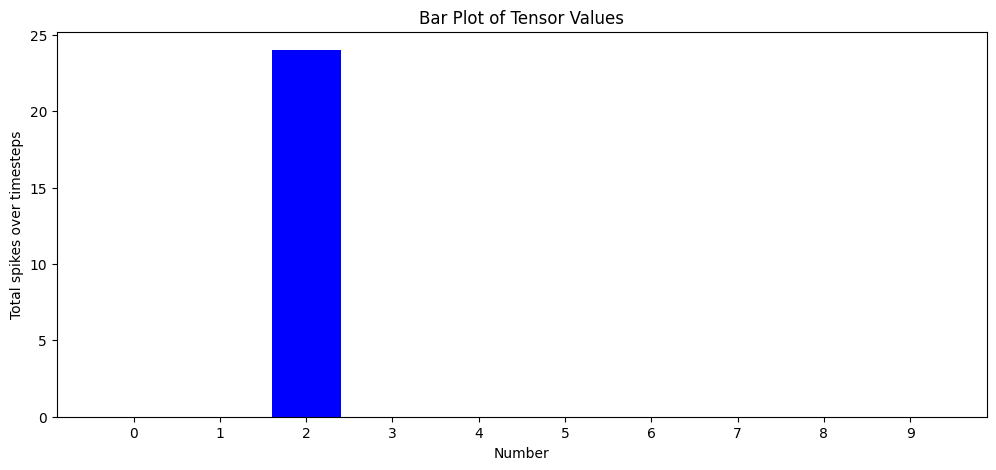

In [196]:
levels = np.arange(0, 10)

# Create the bar plot
plt.figure(figsize=(12, 5))
plt.bar(levels, pred_spike.numpy().ravel(), color='blue')

# Adding titles and labels
plt.xlabel('Number')
plt.ylabel('Total spikes over timesteps')  #overtime
plt.title('Bar Plot of Tensor Values')
plt.xticks(levels)

# Display the plot
plt.show()